In [ ]:
!pip install opencv-python pytesseract

In [ ]:
!sudo apt update && sudo apt install -y tesseract-ocr

In [1]:
%matplotlib inline

import re
import cv2
import csv
import json
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

In [10]:
def parse_pic_to_excel_data(src, debug=False):
    raw = cv2.imread(src, 1)
    # 灰度图片
    gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    # 二值化
    binary = cv2.adaptiveThreshold(~gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, -5)
    if debug:
    #     cv2.imshow("binary_picture", binary)  # 展示图片
        plt.imshow(binary)
        plt.show()
    rows, cols = binary.shape
    scale = 40
    # 自适应获取核值 识别横线
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (cols // scale, 1))
    eroded = cv2.erode(binary, kernel, iterations=1)

    dilated_col = cv2.dilate(eroded, kernel, iterations=1)
    if debug:
    #     cv2.imshow("excel_horizontal_line", dilated_col)
        plt.imshow(dilated_col)
        plt.show()
        # cv2.waitKey(0)
    # 识别竖线
    scale = 20
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, rows // scale))
    eroded = cv2.erode(binary, kernel, iterations=1)
    dilated_row = cv2.dilate(eroded, kernel, iterations=1)
    if debug:
    #     cv2.imshow("excel_vertical_line", dilated_row)
        plt.imshow(dilated_row)
        plt.show()
        # cv2.waitKey(0)
    # 标识交点
    bitwise_and = cv2.bitwise_and(dilated_col, dilated_row)
    if debug:
    #     cv2.imshow("excel_bitwise_and", bitwise_and)
        plt.imshow(bitwise_and)
        plt.show()
        # cv2.waitKey(0)
    # 标识表格
    merge = cv2.add(dilated_col, dilated_row)
#     if debug:
#     cv2.imshow("entire_excel_contour", merge)
    plt.imshow(merge)
    plt.show()
    # cv2.waitKey(0)
    # 两张图片进行减法运算，去掉表格框线
    merge2 = cv2.subtract(binary, merge)
    if debug:
    #     cv2.imshow("binary_sub_excel_rect", merge2)
        plt.imshow(merge2)
        plt.show()

    new_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    erode_image = cv2.morphologyEx(merge2, cv2.MORPH_OPEN, new_kernel)
    if debug:
    #     cv2.imshow('erode_image2', erode_image)
        plt.imshow(erode_image)
        plt.show()
    merge3 = cv2.add(erode_image, bitwise_and)
    if debug:
    #     cv2.imshow('merge3', merge3)
        plt.imshow(merge3)
        plt.show()
        # cv2.waitKey(0)
    # 识别黑白图中的白色交叉点，将横纵坐标取出
    ys, xs = np.where(bitwise_and > 0)
    # 纵坐标
    y_point_arr = []
    # 横坐标
    x_point_arr = []
    # 通过排序，获取跳变的x和y的值，说明是交点，否则交点会有好多像素值值相近，我只取相近值的最后一点
    # 这个10的跳变不是固定的，根据不同的图片会有微调，基本上为单元格表格的高度（y坐标跳变）和长度（x坐标跳变）
    i = 0
    sort_x_point = np.sort(xs)
    for i in range(len(sort_x_point) - 1):
        if sort_x_point[i + 1] - sort_x_point[i] > 10:
            x_point_arr.append(sort_x_point[i])
        i = i + 1
    x_point_arr.append(sort_x_point[i])  # 要将最后一个点加入

    i = 0
    sort_y_point = np.sort(ys)
    # print(np.sort(ys))
    for i in range(len(sort_y_point) - 1):
        if (sort_y_point[i + 1] - sort_y_point[i] > 10):
            y_point_arr.append(sort_y_point[i])
        i = i + 1
    # 要将最后一个点加入
    y_point_arr.append(sort_y_point[i])
    print('y_point_arr', y_point_arr)
    print('x_point_arr', x_point_arr)
    # 循环y坐标，x坐标分割表格
    data = [[] for i in range(len(y_point_arr))]
    for i in range(len(y_point_arr) - 1):
        for j in range(len(x_point_arr) - 1):
            # 在分割时，第一个参数为y坐标，第二个参数为x坐标
            cell = raw[y_point_arr[i]:y_point_arr[i + 1], x_point_arr[j]:x_point_arr[j + 1]]
            if debug:
    #             cv2.imshow("sub_pic" + str(i) + str(j), cell)
                plt.imshow(cell)
                plt.show()

            # 读取文字，此为默认英文
            # pytesseract.pytesseract.tesseract_cmd = 'E:/Tesseract-OCR/tesseract.exe'
            text1 = pytesseract.image_to_string(cell, lang="eng")  # lang="chi_sim"

            # 去除特殊字符
            text1 = re.findall(r'[^\*"/:?\\|<>″′‖ 〈\n]', text1, re.S)
            text1 = "".join(text1)
            if debug:
                print('单元格图片信息：' + text1)
            data[i].append(text1)
            j = j + 1
        i = i + 1
    # cv2.waitKey(0)
    return data


def write_csv(path, data):
    with open(path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file, dialect='excel')
        for index, item in enumerate(data):
            writer.writerows([[item[0], item[1], item[2], item[3], item[4], item[5]]])

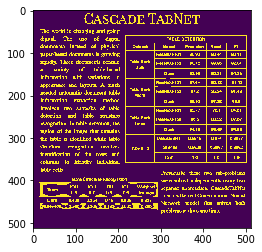

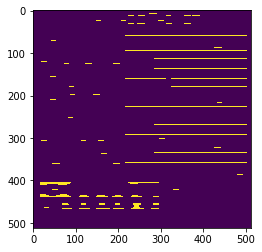

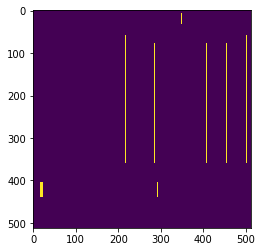

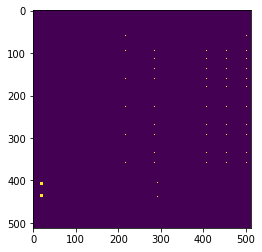

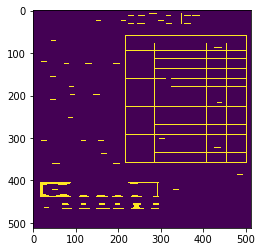

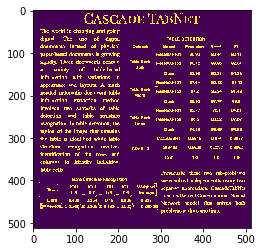

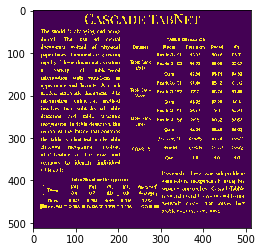

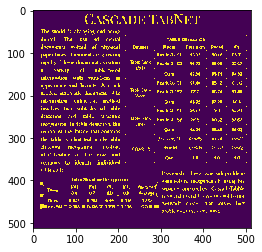

y_point_arr [59, 77, 95, 113, 137, 161, 179, 202, 226, 244, 268, 292, 310, 334, 358, 409, 439]
x_point_arr [22, 217, 293, 352, 407, 454, 501]


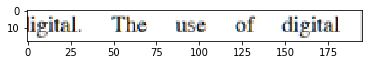

单元格图片信息：igitalTheuseofdigital


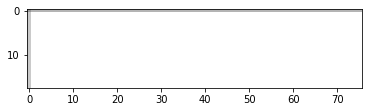

单元格图片信息：


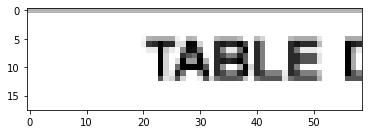

单元格图片信息：‘TABLEf


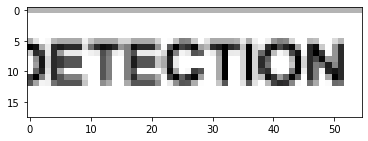

单元格图片信息：JETECTION


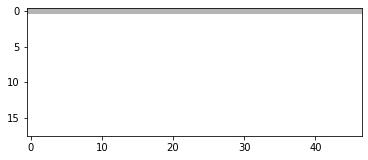

单元格图片信息：


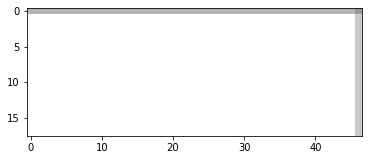

单元格图片信息：


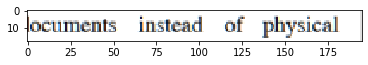

单元格图片信息：jocumentsinsteadofphysical


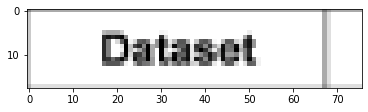

单元格图片信息：Dataset


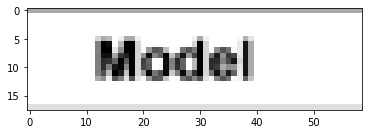

单元格图片信息：‘Model


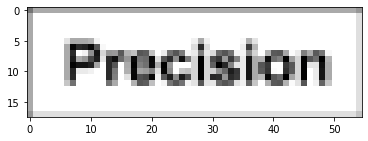

单元格图片信息：Precision


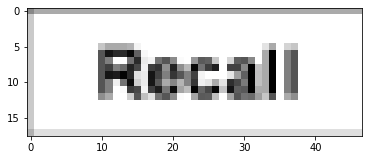

单元格图片信息：Recall


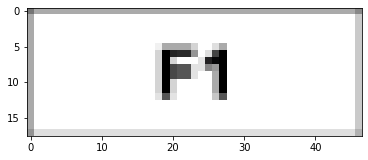

单元格图片信息：Ft


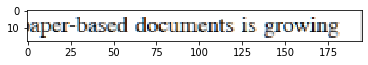

单元格图片信息：aper-baseddocumentsisgrowing


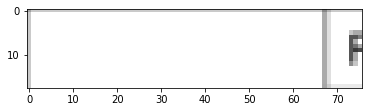

单元格图片信息：


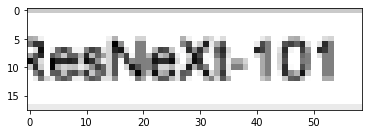

单元格图片信息：fesNeXt-101


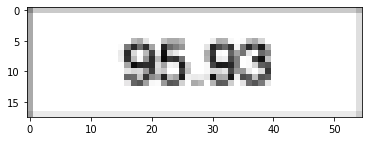

单元格图片信息：95.93


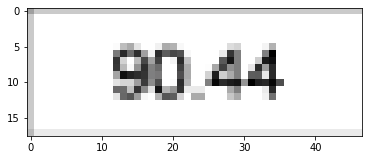

单元格图片信息：


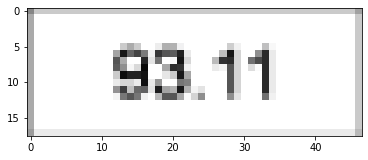

单元格图片信息：93.11


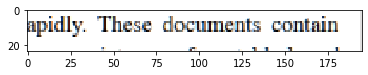

单元格图片信息：apidly.Thesedocumentscontain


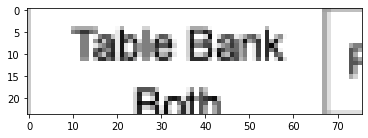

单元格图片信息：‘TableBank


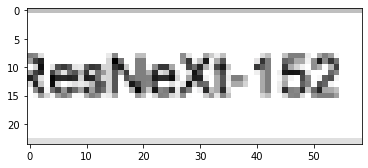

单元格图片信息：tesNeXt-152


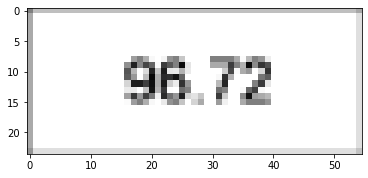

单元格图片信息：9672


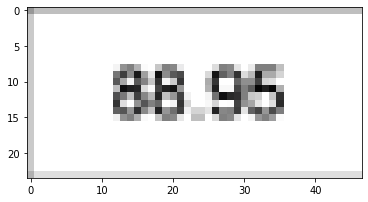

单元格图片信息：88.95,


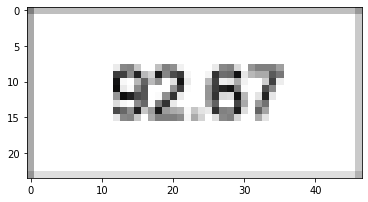

单元格图片信息：9267


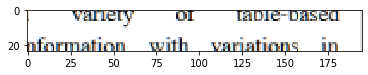

单元格图片信息：Fanteaseces


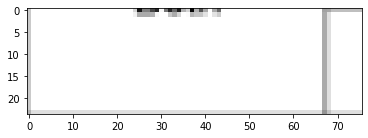

单元格图片信息：


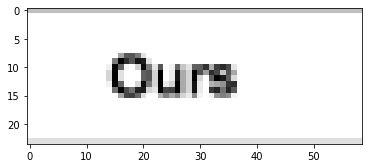

单元格图片信息：Ours


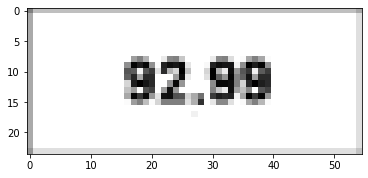

单元格图片信息：


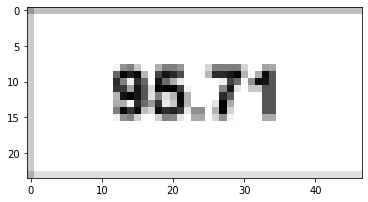

单元格图片信息：


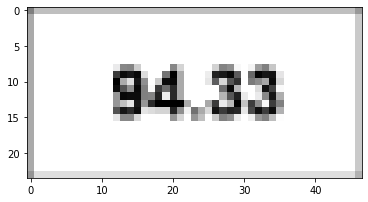

单元格图片信息：


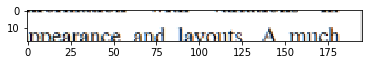

单元格图片信息：


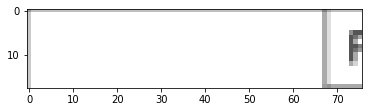

单元格图片信息：


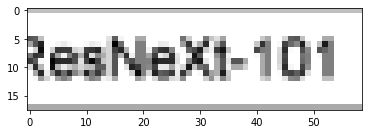

单元格图片信息：fesNeXt-101


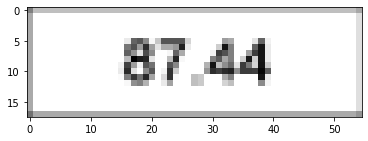

单元格图片信息：87.44


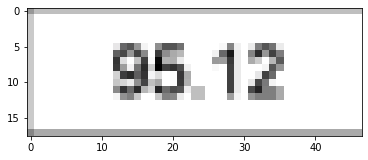

单元格图片信息：95.12


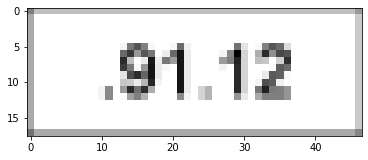

单元格图片信息：9142


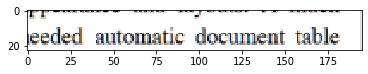

单元格图片信息：eededautomaticdocumenttable


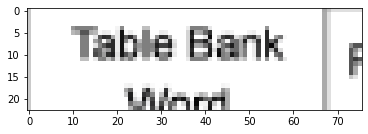

单元格图片信息：‘TableBank


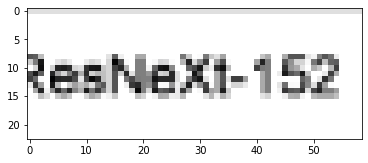

单元格图片信息：tesNeXt-152


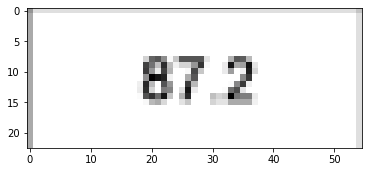

单元格图片信息：872


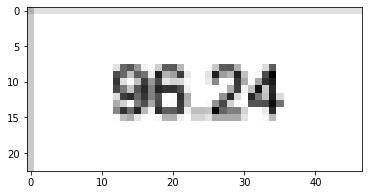

单元格图片信息：


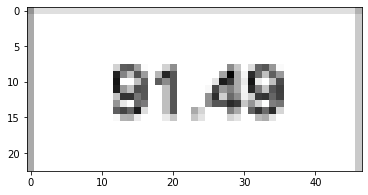

单元格图片信息：91.49


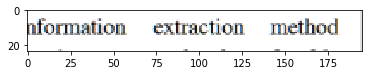

单元格图片信息：formationextractionmethod


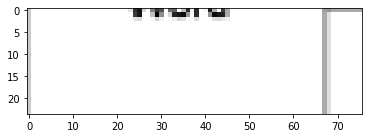

单元格图片信息：


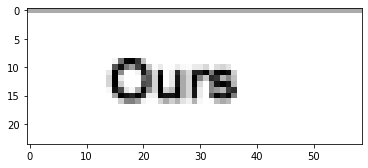

单元格图片信息：


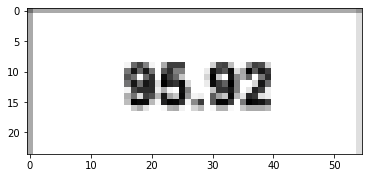

单元格图片信息：95.92


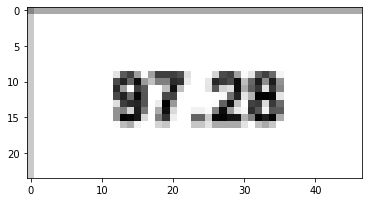

单元格图片信息：


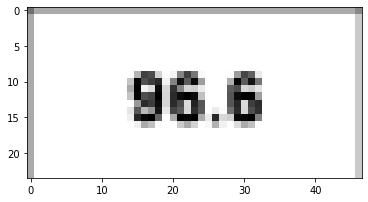

单元格图片信息：


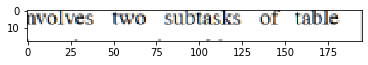

单元格图片信息：nvolvesTWOSUDTASKSOFTable”


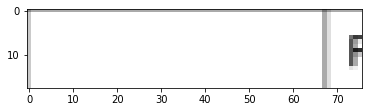

单元格图片信息：


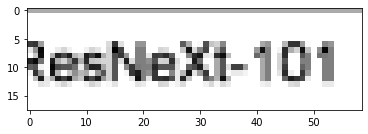

单元格图片信息：fesNeXt-101


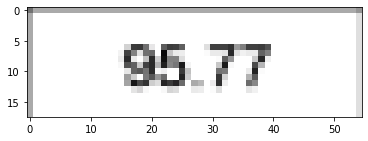

单元格图片信息：9577


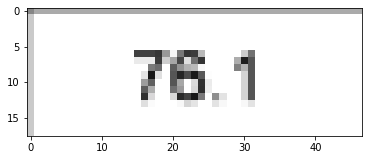

单元格图片信息：


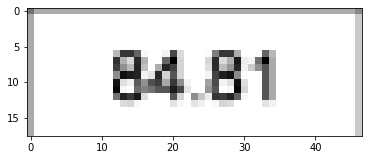

单元格图片信息：84.81


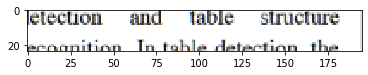

单元格图片信息：


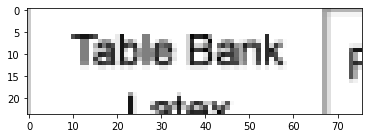

单元格图片信息：TableBank5


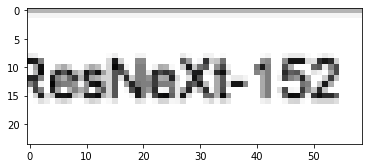

单元格图片信息：tesNeXt-152


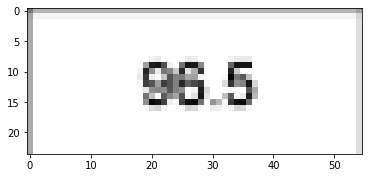

单元格图片信息：965


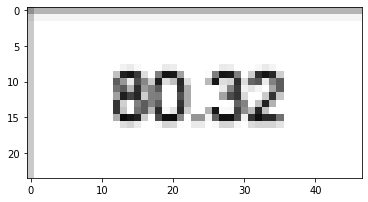

单元格图片信息：


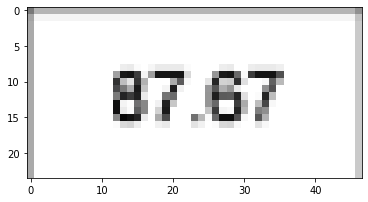

单元格图片信息：


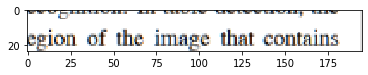

单元格图片信息：esionoftheimagethatcontains


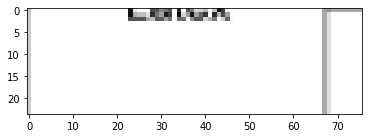

单元格图片信息：


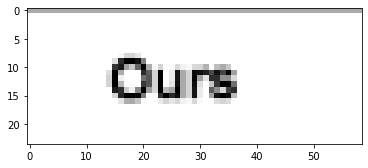

单元格图片信息：


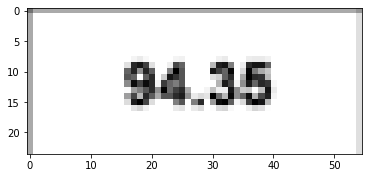

单元格图片信息：9435


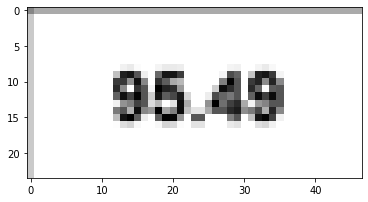

单元格图片信息：


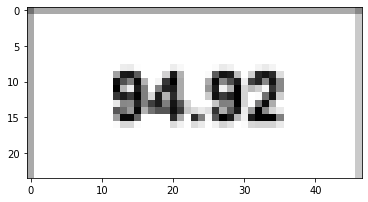

单元格图片信息：9492


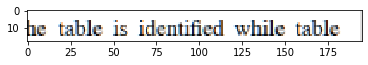

单元格图片信息：hetableisidentifiedwhiletable


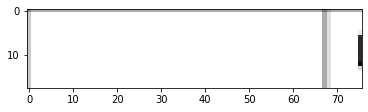

单元格图片信息：


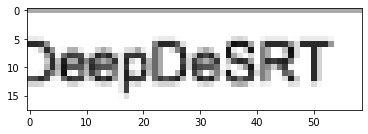

单元格图片信息：DeepDeSRT


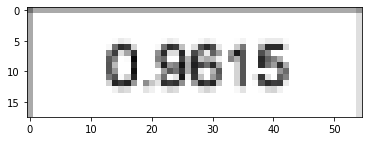

单元格图片信息：0.9615.


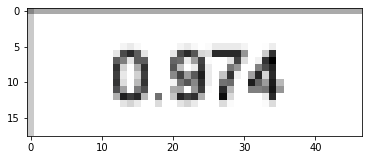

单元格图片信息：0974


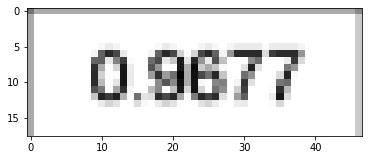

单元格图片信息：0.9677


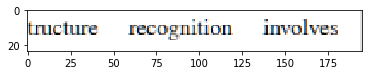

单元格图片信息：tructurerecognitioninvolves


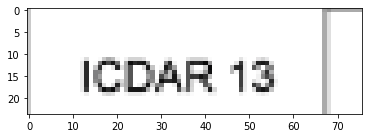

单元格图片信息：ICDAR13


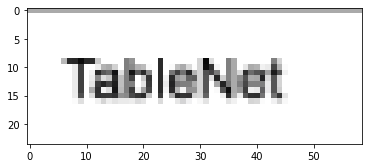

单元格图片信息：TableNet


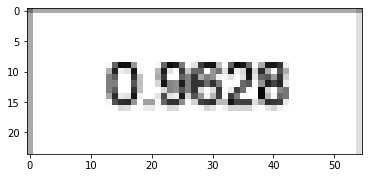

单元格图片信息：


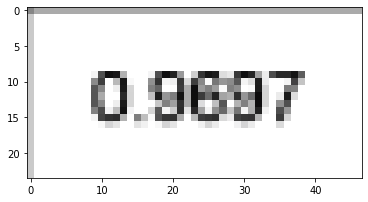

单元格图片信息：0.9697


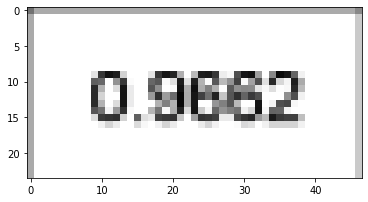

单元格图片信息：


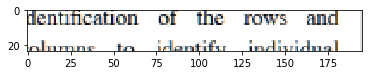

单元格图片信息：Jentificationoftherowsand


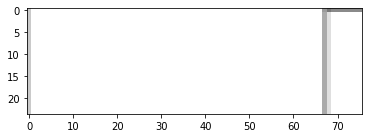

单元格图片信息：


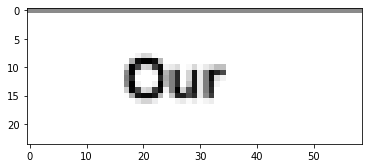

单元格图片信息：‘our


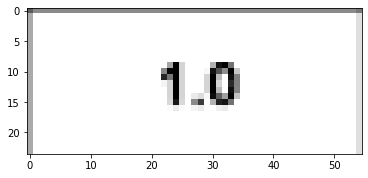

单元格图片信息：


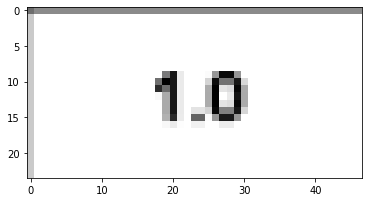

单元格图片信息：10


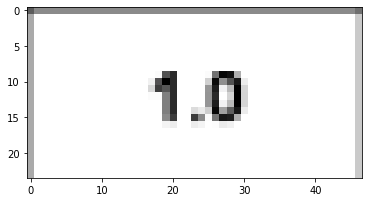

单元格图片信息：


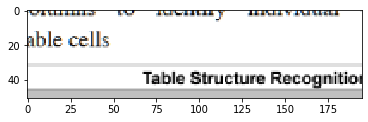

单元格图片信息：“TableStructureRecognitio


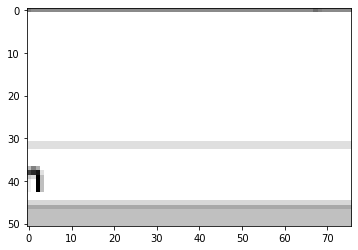

单元格图片信息：


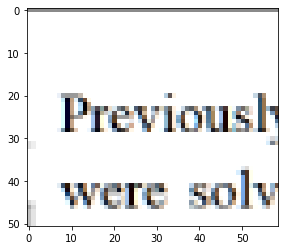

单元格图片信息：Previoustweresolv


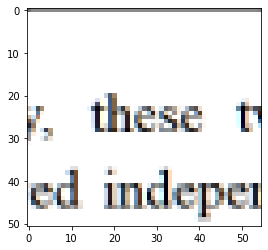

单元格图片信息：theset


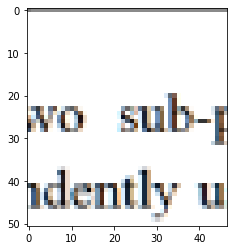

单元格图片信息：vosub-identlyu


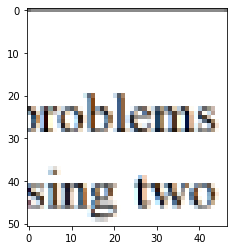

单元格图片信息：roblemssingtwo


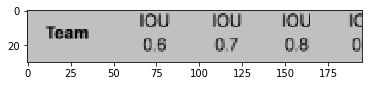

单元格图片信息：foufoutouTeam08«07«608


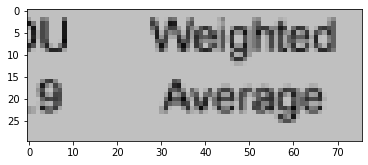

单元格图片信息：UWeighted9Average


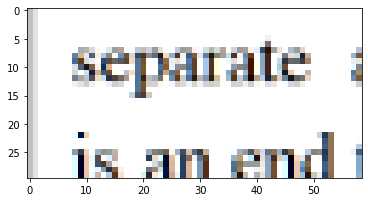

单元格图片信息：separate;oo


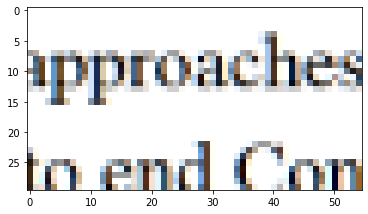

单元格图片信息：pproachesee


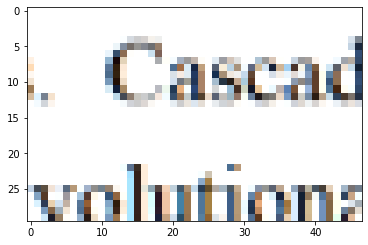

单元格图片信息：Cascadcoshueseums


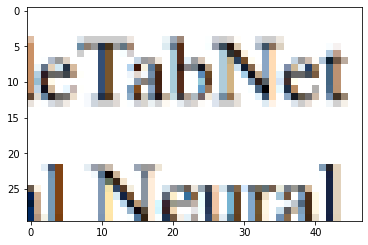

单元格图片信息：eTabNetNeural


In [7]:
file = "demo.png"
# 解析数据
data = parse_pic_to_excel_data(file, debug=True)
# 写入excel
# write_csv(file.replace(".png", ".csv"), data)

打印错位.jpg


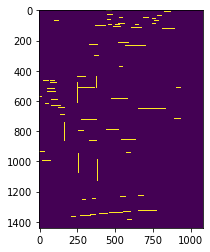

y_point_arr [238, 306, 383, 444, 517, 546, 583, 601, 619, 654, 690, 724, 795, 866, 1223, 1253]
x_point_arr [167, 263, 387, 935]
质量好外围空间较大.jpg


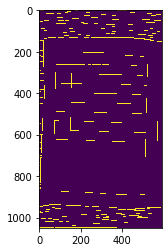

y_point_arr [146, 163, 174, 196, 232, 249, 274, 327, 363, 383, 408, 421, 457, 500, 519, 547, 579, 600, 624, 638, 655, 668, 710, 748, 782, 806, 840, 859, 889]
x_point_arr [22, 81, 158, 521]
发黄.jpg


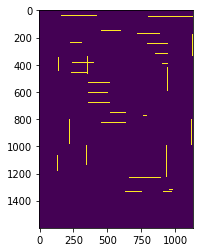

y_point_arr [174, 246, 319, 392, 465, 537, 610, 683, 756, 829, 1235]
x_point_arr [230, 357, 946, 1115]
质量好-独立产权.jpg


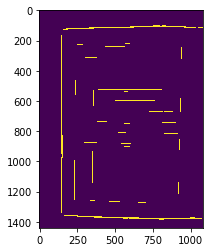

y_point_arr [246, 315, 385, 456, 528, 600, 672, 735, 806, 886, 1252]
x_point_arr [244, 360, 938]
质量好有阴影.jpg


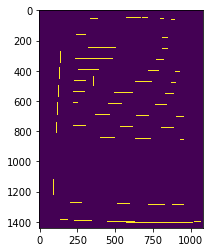

y_point_arr [248, 320, 394, 467, 541, 555, 629, 689, 703, 779, 855, 1284]
x_point_arr [364, 954]
质量好.jpg


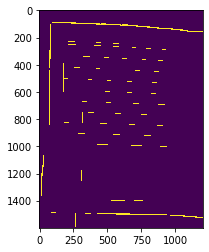

y_point_arr [341, 424, 508, 589, 671, 750, 829, 903, 1392, 1490]
x_point_arr [181, 268, 324]
mmexport1607322847441.pic_hd.jpg


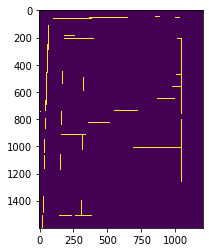

y_point_arr [209, 296, 382, 473, 557, 651, 740, 830, 920, 1010, 1510]
x_point_arr [25, 174, 329, 1042]
多人共有含比例.jpg


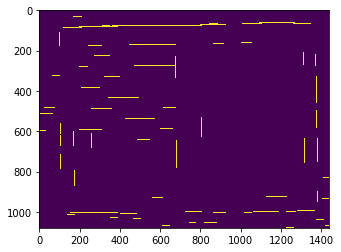

y_point_arr [176, 227, 278, 331, 383, 435, 489, 541, 593, 644, 929, 951]
x_point_arr [103, 170, 267, 680, 1382]
多人共有.jpg


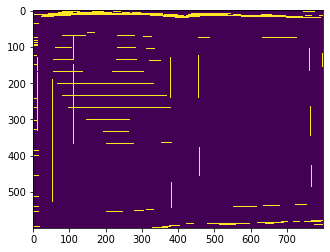

y_point_arr [76, 102, 175, 204, 243, 305, 335, 364, 417, 443, 534]
x_point_arr [13, 54, 111, 381, 769]
mmexport1607322541739.pic_hd.jpg


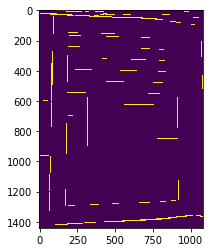

y_point_arr [171, 199, 243, 290, 318, 394, 470, 557, 629, 661, 701, 775, 852, 963, 1293]
x_point_arr [92, 190, 323, 915]
质量好但有弯曲.jpg


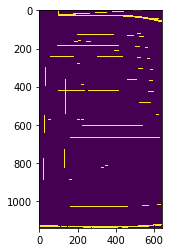

y_point_arr [32, 130, 187, 244, 303, 362, 422, 483, 545, 606, 669, 1027]
x_point_arr [38, 102, 142]
质量好 外围有干扰.jpg


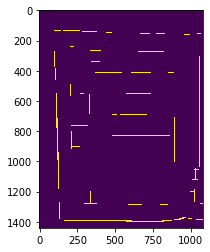

y_point_arr [273, 343, 412, 482, 552, 623, 693, 762, 831, 901, 1053, 1103, 1177, 1198, 1246, 1262, 1280]
x_point_arr [218, 339, 892, 1031, 1054]
字较浅打印跨行.jpg


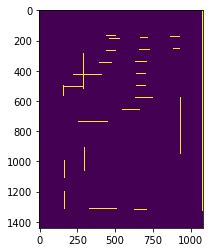

y_point_arr [174, 254, 271, 334, 350, 415, 428, 506, 574, 660, 737, 814, 892, 1323]
x_point_arr [169, 302, 931]
质量好有印章.jpg


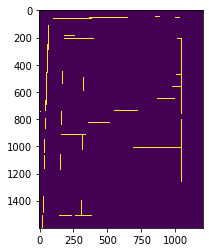

y_point_arr [209, 296, 382, 473, 557, 651, 740, 830, 920, 1010, 1510]
x_point_arr [25, 174, 329, 1042]
质量好-略微倾斜.jpg


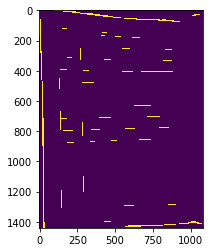

y_point_arr [235, 318, 474, 556, 636, 716, 796, 878]
x_point_arr [144, 288]
阴影.jpg


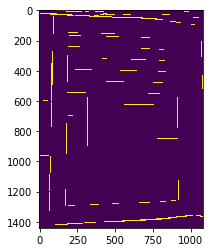

y_point_arr [171, 199, 243, 290, 318, 394, 470, 557, 629, 661, 701, 775, 852, 963, 1293]
x_point_arr [92, 190, 323, 915]
占比太小.jpg


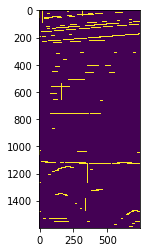

y_point_arr [39, 137, 410, 465, 514, 563, 612, 661, 710, 761, 1062, 1094, 1130, 1175, 1397, 1458, 1507]
x_point_arr [7, 29, 82, 164, 318, 337, 353, 374, 565, 679]
斜上方拍摄-外围有干扰.jpg


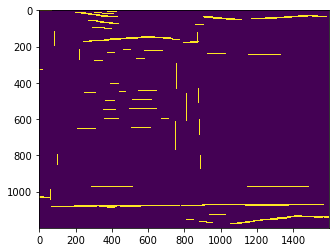

y_point_arr [51, 178, 975, 1036]
x_point_arr [63, 749, 874, 1179]
质量好旋转了.jpg


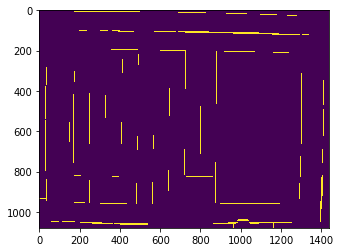

y_point_arr [204, 825, 937, 961, 1058]
x_point_arr [39, 175, 251, 328, 406, 486, 565, 651, 728, 805, 881, 965, 1164, 1250, 1297]


In [11]:
import os

image_dir = './images/'
filenames = os.listdir(image_dir)
for filename in filenames:
    print(filename)
    # Test a single image 
    file = os.path.join(image_dir, filename)

    # Run Inference
    # 解析数据
    data = parse_pic_to_excel_data(file, debug=False)
    # 写入excel
    # write_csv(file.replace(".jpg", ".csv"), data)
